In [151]:
%%time
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy import stats
import subprocess
from pathlib import Path
import csv
import pyproj
from shapely.ops import transform
from functools import partial
import xlrd
import numpy as np
from io import StringIO
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Numeric
from sqlalchemy.orm import sessionmaker
import dask.dataframe as das
from shapely.geometry import Point, Polygon
import sqlite3
import datetime

Wall time: 10.1 ms


In [110]:
#read in the twitter data in box
au_twitter = pd.read_csv('C:\\Users\\emman\\box\\Twitter data\\Asia\\Sydney\\sydney.csv')

In [112]:
au_twitter.dropna(inplace=True)

In [113]:
au_twitter.head()

,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069
1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209


In [114]:
au_twitter.shape

(6450144, 14)

Based on what I'm seeing from the `Yurika_twitter_analysis_10_11.ipynb` notebook, they were able to give each tweet a certain geographical boundary, which I'm assuming was done by assigning lat/long within a certain range a specific census tract. I have the shapefiles for a particular boundary in Sydney, so maybe we can use that?

In [116]:
# Create a shapely.geometry.Point for each tweet
geometry = [Point(xy) for xy in zip(au_twitter['location.lon'], au_twitter['location.lat'])]
crs = {'init' :'epsg:4326'}

In [117]:
# Convert to GeoDataFrame, where each tweet's geometry is assigned to the lat/lon coords
twt_gdf = gpd.GeoDataFrame(au_twitter, crs=crs, geometry=geometry)

In [118]:
print(twt_gdf.shape)
twt_gdf.head()

(6450144, 15)


,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,geometry
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,POINT (151.21962664 -33.8780691)
1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059,POINT (151.08905613 -33.86905872)
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,POINT (150.94787082 -33.79827494)
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,POINT (151.1780059 -33.80927427)
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,POINT (151.22299293 -33.91220949)


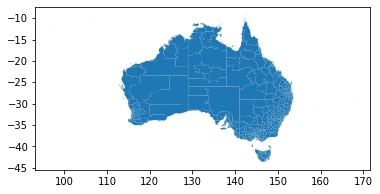

In [121]:
# Read Australia SA2 shapefiles
au_shape_sa2 = gpd.read_file('C:\\Users\\emman\\box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\SA2 Shapefiles\\SA2_2016_AUST.dbf')
# Crikey, our area is too big
au_shape_sa2.plot()
# We also need to change the crs 
au_shape_sa2.crs = {'init': 'epsg:4326'}

In [162]:
# have the shapefile only have areas that are in the state of New South Wales, and furthermore, in Greater Sydney
au_shape_sa2 = au_shape_sa2[au_shape_sa2.STE_NAME16 == 'New South Wales']
au_shape_sa2 = au_shape_sa2[au_shape_sa2.GCC_NAME16 == 'Greater Sydney']

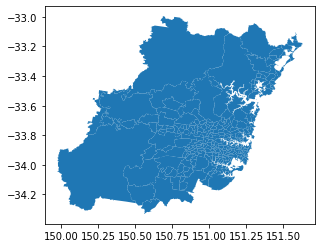

In [26]:
au_shape_sa2.plot()

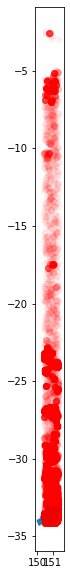

In [28]:
fig, ax = plt.subplots(figsize=(14, 10))
au_shape_sa2['geometry'].plot(ax=ax)
twt_gdf.plot(ax=ax, marker='o', color='red', alpha=0.05);

Hey, that's really stupid and uninformative. Maybe there's a better way?

In [141]:
au_shape_sa2.dropna(inplace=True)

In [54]:
twt_gdf.describe()

,id,created_at,u_id,u_created_at,u_followers_count,u_friends_count,location.lon,location.lat
count,7.262133e+06,7.262133e+06,7.262133e+06,7.262133e+06,7.262133e+06,7.262133e+06,7.262133e+06,7.262133e+06
mean,4.502255e+17,1.396177e+12,1.288103e+15,1.295288e+12,1.461053e+03,7.104179e+02,1.511113e+02,-3.374603e+01
std,1.355597e+17,3.231995e+10,3.125602e+16,5.440270e+10,1.929849e+04,2.383125e+03,1.536285e-01,9.932214e-01
min,2.253637e+17,1.342566e+12,1.500000e+01,0.000000e+00,-1.000000e+00,-1.000000e+00,1.504608e+02,-3.414781e+01
25%,3.448077e+17,1.371044e+12,5.232939e+07,1.246345e+12,1.010000e+02,1.390000e+02,1.510195e+02,-3.389684e+01
50%,4.371440e+17,1.393058e+12,2.321528e+08,1.293708e+12,2.760000e+02,3.140000e+02,1.511793e+02,-3.387158e+01
75%,5.446966e+17,1.418701e+12,5.355309e+08,1.332606e+12,7.980000e+02,7.430000e+02,1.512107e+02,-3.380820e+01
max,7.954513e+17,1.478485e+12,7.921684e+17,1.477703e+12,8.339538e+06,3.217600e+05,1.513516e+02,-2.500000e+00


In [55]:
twt_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7262133 entries, 0 to 7262132
Data columns (total 15 columns):
id                   int64
created_at           float64
text                 object
u_id                 int64
u_name               object
u_created_at         float64
u_description        object
u_followers_count    int64
type                 object
c_country            object
u_screen_name        object
u_friends_count      int64
location.lon         float64
location.lat         float64
geometry             object
dtypes: float64(4), int64(4), object(7)
memory usage: 831.1+ MB


In [56]:
twt_gdf['type'].value_counts()

ll     3893574
llp    3368559
Name: type, dtype: int64

In [74]:
twt_gdf_sub = twt_gdf[:10000]

In [77]:
twt_gdf.crs

{'init': 'epsg:4326'}

In [119]:
au_shape_sa2 = {'init': 'epsg:4326'}

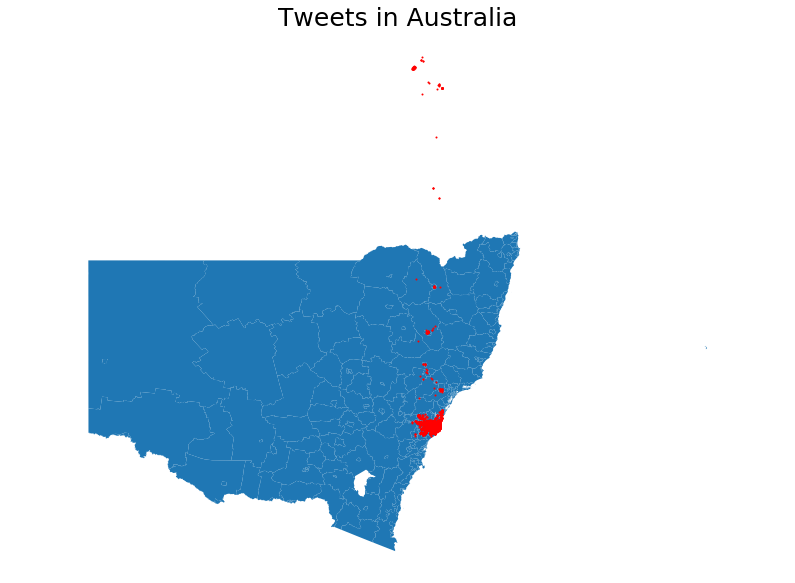

In [75]:
figure, ax = plt.subplots(figsize=(14,10))
base = au_shape_sa2.plot(ax=ax)
twt_gdf_sub.plot(ax=base, markersize=1, color="Red")
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('Tweets in Australia', fontdict= 
            {'fontsize':25})

plt.show()

In [87]:
twt_gdf_sub

,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,geometry
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,POINT (151.21962664 -33.8780691)
1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059,POINT (151.08905613 -33.86905872)
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,POINT (150.94787082 -33.79827494)
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,POINT (151.1780059 -33.80927427)
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,POINT (151.22299293 -33.91220949)
5,227394131700363265,1.343050e+12,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,42222507,Riastini Ratnasari,1.243177e+12,☮ I am an happilionaire ;DDDD\nAm blessed and ...,1008,ll,AUS,gektien,415,151.109044,-33.770251,POINT (151.10904395 -33.77025111)
6,227394165061844992,1.343050e+12,Eu sou tão triste que nunca fui ao starbucks!,61506006,Mara Moura,1.248965e+12,19. It's the quality of one's convictions tha...,219,ll,AUS,MaraVFMoura,146,151.104728,-33.904342,POINT (151.10472805 -33.9043423)
7,227395279807184897,1.343050e+12,Success! Candied cashews! New drunk kitchen ri...,192788617,Sarah A. Dwyer,1.284956e+12,"A loud, loud, LOUD musical theatre performer.",11,ll,AUS,dwyertype,43,150.994503,-33.784471,POINT (150.9945027 -33.78447083)
8,227395507469819904,1.343050e+12,So witty babe #shitjakesays,82075723,emelia,1.255435e+12,NaN,192,ll,AUS,Emeliargh,116,151.166840,-33.731489,POINT (151.16683957 -33.73148934)
9,227396552409358336,1.343051e+12,I'm gunna be soooo tired tomorrow. I finished ...,157205157,Ashley Goldsmith,1.276921e+12,"I have a green belt, read it and weep.",273,ll,AUS,AsheeGoldsmith,142,151.291995,-33.730853,POINT (151.29199522 -33.73085325)


In [153]:
twtsa2_gdf = gpd.sjoin(twt_gdf,au_shape_sa2,how='left',op='within')

In [154]:
twtsa2_gdf

,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,geometry,index_right,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,POINT (151.21962664 -33.8780691),339.0,117031329,11329,Darlinghurst,11703,Sydney Inner City,117,Sydney - City and Inner South,1GSYD,Greater Sydney,1,New South Wales,0.8569
1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059,POINT (151.08905613 -33.86905872),413.0,120031575,11575,Strathfield,12003,Strathfield - Burwood - Ashfield,120,Sydney - Inner West,1GSYD,Greater Sydney,1,New South Wales,6.4515
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,POINT (150.94787082 -33.79827494),518.0,125041588,11588,Pendle Hill - Girraween,12504,Parramatta,125,Sydney - Parramatta,1GSYD,Greater Sydney,1,New South Wales,4.4615
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,POINT (151.1780059 -33.80927427),416.0,121011399,11399,Chatswood (West) - Lane Cove North,12101,Chatswood - Lane Cove,121,Sydney - North Sydney and Hornsby,1GSYD,Greater Sydney,1,New South Wales,5.5372
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,POINT (151.22299293 -33.91220949),360.0,118021564,11564,Kensington (NSW),11802,Eastern Suburbs - South,118,Sydney - Eastern Suburbs,1GSYD,Greater Sydney,1,New South Wales,2.6422
5,227394131700363265,1.343050e+12,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,42222507,Riastini Ratnasari,1.243177e+12,☮ I am an happilionaire ;DDDD\nAm blessed and ...,1008,ll,AUS,gektien,415,151.109044,-33.770251,POINT (151.10904395 -33.77025111),525.0,126021500,11500,Macquarie Park - Marsfield,12602,Ryde - Hunters Hill,126,Sydney - Ryde,1GSYD,Greater Sydney,1,New South Wales,10.6720
6,227394165061844992,1.343050e+12,Eu sou tão triste que nunca fui ao starbucks!,61506006,Mara Moura,1.248965e+12,19. It's the quality of one's convictions tha...,219,ll,AUS,MaraVFMoura,146,151.104728,-33.904342,POINT (151.10472805 -33.9043423),378.0,119021363,11363,Canterbury (South) - Campsie,11902,Canterbury,119,Sydney - Inner South West,1GSYD,Greater Sydney,1,New South Wales,4.7777
7,227395279807184897,1.343050e+12,Success! Candied cashews! New drunk kitchen ri...,192788617,Sarah A. Dwyer,1.284956e+12,"A loud, loud, LOUD musical theatre performer.",11,ll,AUS,dwyertype,43,150.994503,-33.784471,POINT (150.9945027 -33.78447083),514.0,125041491,11491,Northmead,12504,Parramatta,125,Sydney - Parramatta,1GSYD,Greater Sydney,1,New South Wales,5.9332
9,227396552409358336,1.343051e+12,I'm gunna be soooo tired tomorrow. I finished ...,157205157,Ashley Goldsmith,1.276921e+12,"I have a green belt, read it and weep.",273,ll,AUS,AsheeGoldsmith,142,151.291995,-33.730853,POINT (151.29199522 -33.73085325),450.0,122031431,11431,Narrabeen - Collaroy,12203,Warringah,122,Sydney - Northern Beaches,1GSYD,Greater Sydney,1,New South Wales,7.1622
10,227419998883307520,1.343056e+12,Oh. My. God. Stop that now. #jamesfranco @ We...,320118110,Jacqueline Lennon,1.308478e+12,I write. I'm still refining & learning how is ...,16,ll,AUS,jaclostjill,78,151.191132,-33.904385

In [155]:
twtsa2_gdf = twtsa2_gdf[twtsa2_gdf.STE_NAME16=='New South Wales']

In [157]:
twtsa2_gdf.shape

(6261909, 28)

In [159]:
twtsa2_gdf = twtsa2_gdf[twtsa2_gdf.GCC_NAME16=='Greater Sydney']

In [160]:
twtsa2_gdf.shape

(6178094, 28)

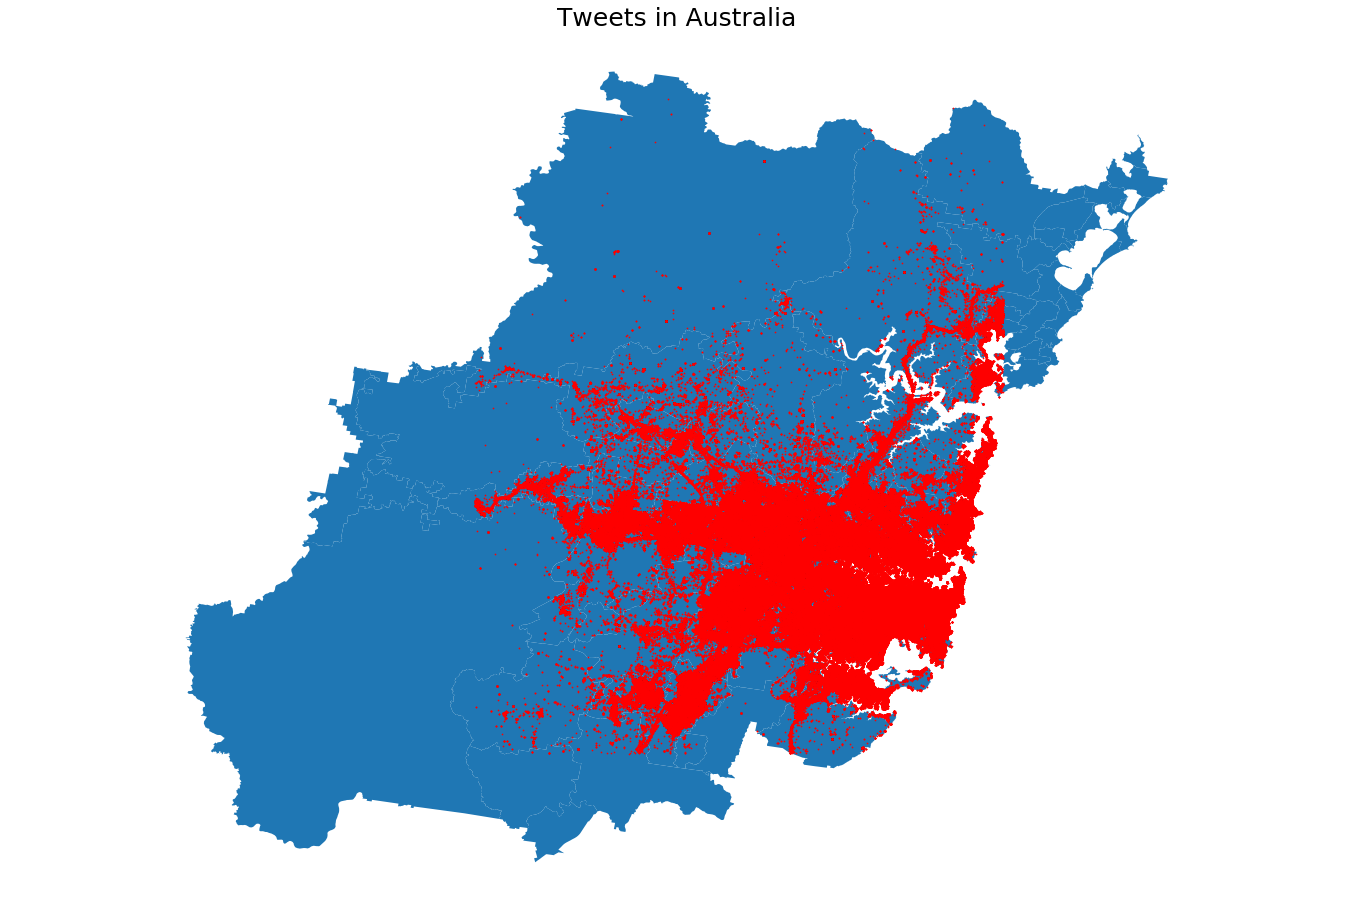

In [164]:
figure, ax = plt.subplots(figsize=(24,16))
base = au_shape_sa2.plot(ax=ax)
twtsa2_gdf.plot(ax=base, markersize=.5, color="Red")
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('Tweets in Australia', fontdict= 
            {'fontsize':25})

plt.show()

In [165]:
print("this line of code")

this line of code
